In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Data preparation

After taking a closer look to the dataset and its meaning, we have decided to use the variable `koi_disposition` as our target variable, which is the data observed by humans. We can see that is a categorical variable containing three classes; False Positive, Confirmed, and Candidate. In order to simplify this analysis, we are going to remove the False Positive cases while trying to predict the Confirmed and Candidate cases, transforming our analysis into a binary classification.

We have removed the variables `kepid` and `kepler_name` since they only serve to identify the points and add no significant information.\
We also removed `koi_score` since this is the confidence on the machine's prediction and it shall not be used as predictive variable.\
Other variable we removed were `koi_teq_err1` and `koi_teq_err2` since they only contained missing values.\
Finaly, we used `kepoi_name` as the index to identify the rows, as it shows the scientific name of the Kepler object of interest.

In [12]:
data = pd.read_csv('exoplanets.csv')

In [13]:
data.head()

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [14]:
# Drop unnecessary variables
exclude_variables = ["kepid","kepler_name","koi_pdisposition","koi_score","koi_teq_err1","koi_teq_err2"]
df = data.drop(columns=exclude_variables).set_index("kepoi_name")

In [15]:
# Set up target variable
# Use koi_disposition only when it is not a FALSE POSITIVE
df = df.where(df["koi_disposition"] != "FALSE POSITIVE").dropna(axis=0,how="all")
df["koi_disposition"] = df["koi_disposition"].astype("category")
print(df["koi_disposition"].value_counts())


koi_disposition
CANDIDATE    2367
CONFIRMED    2357
Name: count, dtype: int64


In [18]:
def variable_stats_table(df):
    data_stats = {}
    nrow=len(df)
    for col in df:
        var = df[col]
        data_stats[col] = {}
        data_stats[col]["%miss"] = (var.isnull().sum()/nrow)*100
        data_stats[col]["#unique"] = len(var.drop_duplicates())
        data_stats[col]["type"] = var.dtype.kind
        if data_stats[col]["type"] != "O":
            # Not categorical
            if data_stats[col]["#unique"] > 2:
                # Not Binary
                data_stats[col]["min"] = var.min()
                data_stats[col]["max"] = var.max()
                data_stats[col]["mean"] = var.mean()
                data_stats[col]["median"] = var.median()
                data_stats[col]["std"] = var.std()

    return pd.DataFrame(data_stats).T

variable_stats_table(df)

,%miss,#unique,type,min,max,mean,median,std
koi_disposition,0.0,2,O,NaN,NaN,NaN,NaN,NaN
koi_fpflag_nt,0.0,3,f,0.0,465.0,0.099069,0.0,6.765508
koi_fpflag_ss,0.0,2,f,NaN,NaN,NaN,NaN,NaN
koi_fpflag_co,0.0,1,f,NaN,NaN,NaN,NaN,NaN
koi_fpflag_ec,0.0,1,f,NaN,NaN,NaN,NaN,NaN
koi_period,0.0,4724,f,0.25982,129995.7784,86.473804,13.379241,1894.537558
koi_period_err1,2.561389,2308,f,0.0,0.142,0.001548,0.000071,0.00584
koi_period_err2,2.561389,2308,f,-0.142,0.0,-0.001548,-0.000071,0.00584
koi_time0bk,0.0,4720,f,120.565925,907.04471,166.950094,140.828355,63.866958
koi_time0bk_err1,2.561389,1594,f,0.000009,0.488,0.00935,0.00466,0.021733


From these results, we notice that `koi_fpflag_co` and `koi_fpflag_ec` are always equal to 0 and we decided to drop them. The first variable represents the Centroid Offset Flag while the second the Ephemeris Match Indicates Contamination Flag. 

Regarding the first variable, the statement shows that the source of the signal is from a nearby star, as inferred by measuring the centroid location of the image both in and out of transit, or  by the strength of the transit signal in the target's outer (halo) pixels as compared to the transit signal from the pixels in the optimal (or core) aperture. Either way, a false positivie suggests the source isn't coming from an exoplanet, so we drop it. 

The scientists can evalueate this by measuring the centroid location of the image both when the exoplanet is in front of the star (in transit) and when it is not. The centroid is essentially the center of the image. If the centroid shifts significantly when the exoplanet is in transit, it suggests that the transit signal is not coming from the exoplanet, but from a nearby star. In the other case, they can look at the strength of the transit signal in the outer pixels (halo) of the image compared to the signal from the core pixels (optimal aperture). If the transit signal is stronger in the outer pixels, it suggests that it is not coming from the exoplanet, but from a nearby star.

When it comes to the second variable, the statement means that the KOI in question has the same period and epoch as another object. This suggests that what was detected may not actually be a planet, but rather a result of "flux contamination" or "electronic crosstalk". Flux contamination refers to the interference from other sources of light, such as nearby stars, while electronic crosstalk refers to the interference caused by the electronics of the telescope itself.
Therefore, the statement suggests that the detection of the potential exoplanet is not valid, as it is likely a false positive caused by technical issues with the telescope or other sources of light, hence it is dropped.

Another variables that we decided to drop was `koi_fpflag_nt`, which stand for Non Transit-Like Flag. It has only three entries that are non zero while all the rest are. This means that the light curve of these three objects is not consistent with that of a transiting planet and could be anything from an instrumental artifact to spurious detections.

Finally, we completely removing any rows who had missing values. As it can be seen below, these rows were only 194 in total so removing them would not severely affect the size of our dataset.


In [20]:
print(f"By droping missing values we go from {len(df)} registers to {len(df.dropna())}")
print(len(df))
print(len(df.dropna()))

By droping missing values we go from 4724 registers to 4530
4724
4530


## Feature engineering

In [21]:
# Explore potential categorical variables
for var in ["koi_disposition","koi_tce_plnt_num","koi_tce_delivname","koi_fpflag_co","koi_fpflag_ec","koi_fpflag_nt","koi_fpflag_ss"]:
    print(df[var].value_counts())
    print()

koi_disposition
CANDIDATE    2367
CONFIRMED    2357
Name: count, dtype: int64

koi_tce_plnt_num
1.0    3485
2.0     758
3.0     268
4.0      97
5.0      33
6.0      10
7.0       3
Name: count, dtype: int64

koi_tce_delivname
q1_q17_dr25_tce    4108
q1_q16_tce          402
q1_q17_dr24_tce     144
Name: count, dtype: int64

koi_fpflag_co
0.0    4724
Name: count, dtype: int64

koi_fpflag_ec
0.0    4724
Name: count, dtype: int64

koi_fpflag_nt
0.0      4720
1.0         3
465.0       1
Name: count, dtype: int64

koi_fpflag_ss
0.0    4708
1.0      16
Name: count, dtype: int64



In [22]:
# By exploring, we find that koi_fpflag_co koi_fpflag_ec only contain one distinct value so we drop them
# Also koi_fpflag_nt and koi_fpflag_ss almost all their entries with the same value. We will drop them or not.
df = df.drop(columns=["koi_fpflag_co","koi_fpflag_ec"])
df = df.drop(columns=["koi_fpflag_nt"])
df = df.dropna()

In [23]:
# Convert to categorical
df["koi_disposition"] = pd.Categorical(df["koi_disposition"])
df["koi_tce_plnt_num"] = pd.Categorical(df["koi_tce_plnt_num"],ordered=True)
df["koi_tce_delivname"] = pd.Categorical(df["koi_tce_delivname"])
df["koi_fpflag_ss"] = pd.Categorical(df["koi_fpflag_ss"])


In [24]:
variable_stats_table(df)

,%miss,#unique,type,min,max,mean,median,std
koi_disposition,0.0,2,O,NaN,NaN,NaN,NaN,NaN
koi_fpflag_ss,0.0,2,O,NaN,NaN,NaN,NaN,NaN
koi_period,0.0,4530,f,0.25982,1071.232624,54.738119,13.032044,107.637326
koi_period_err1,0.0,2286,f,0.0,0.142,0.001528,0.00007,0.005842
koi_period_err2,0.0,2286,f,-0.142,-0.0,-0.001528,-0.00007,0.005842
koi_time0bk,0.0,4526,f,120.565925,907.04471,166.049678,140.49982,62.631289
koi_time0bk_err1,0.0,1581,f,0.000009,0.488,0.009276,0.00465,0.021745
koi_time0bk_err2,0.0,1581,f,-0.488,-0.000009,-0.009276,-0.00465,0.021745
koi_impact,0.0,1431,f,0.0,86.1724,0.527987,0.3867,2.516038
koi_impact_err1,0.0,991,f,0.0,74.31,0.86981,0.212,6.057108


## Exploratory data analysis

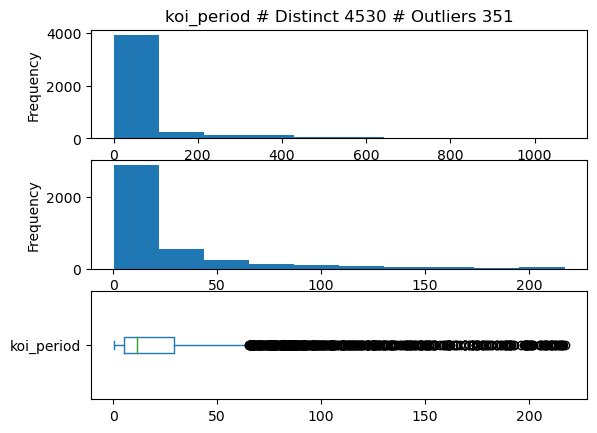

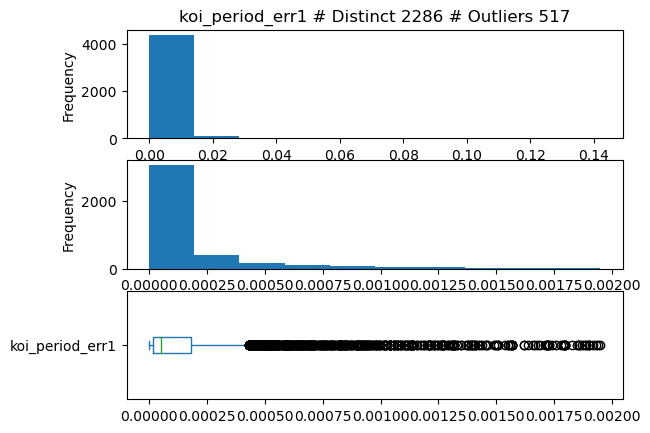

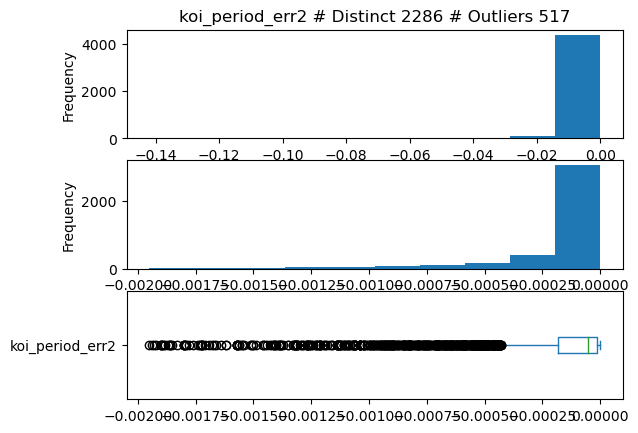

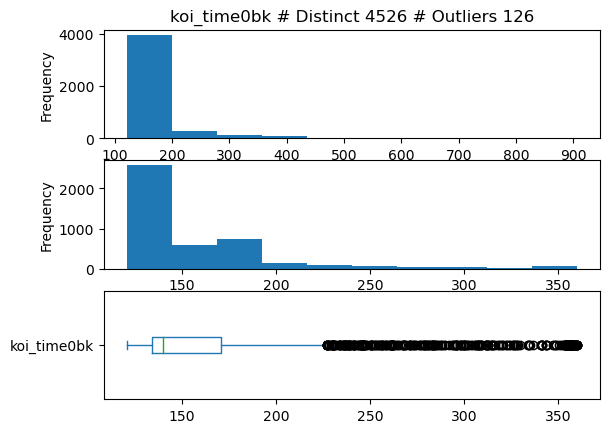

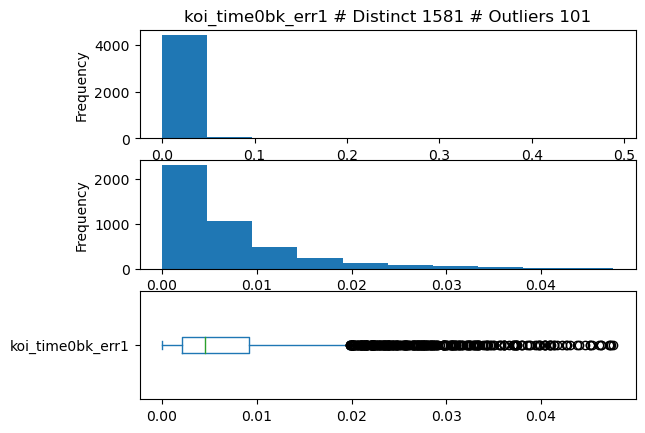

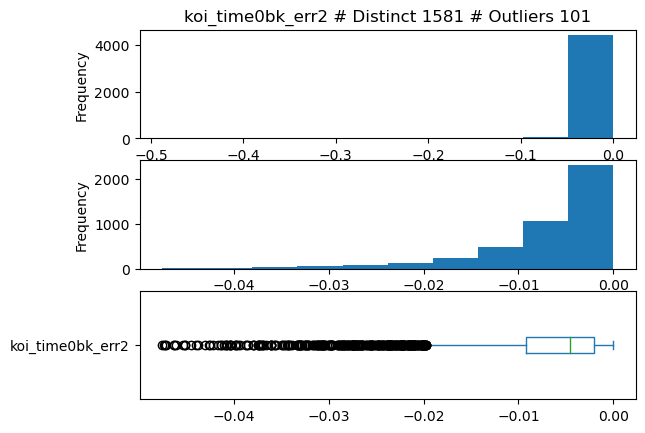

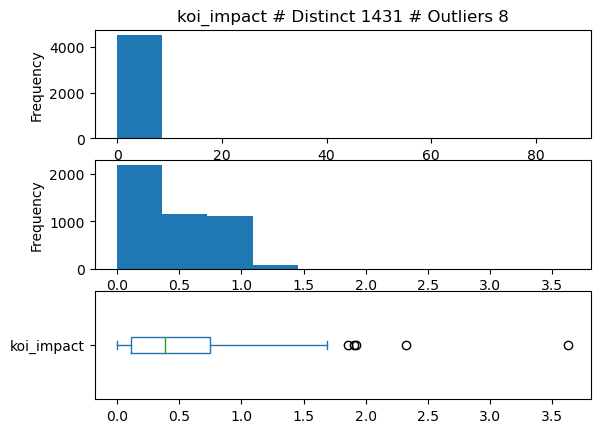

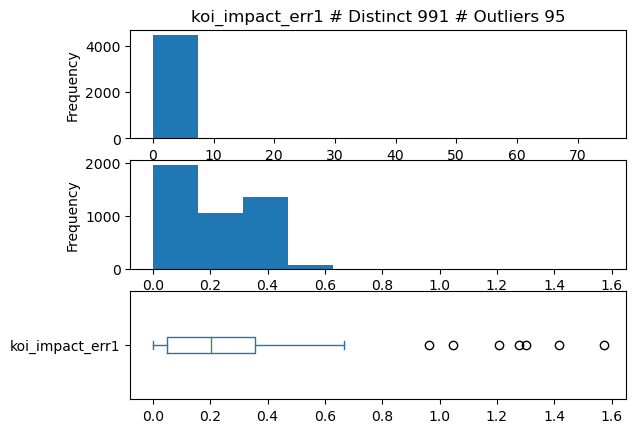

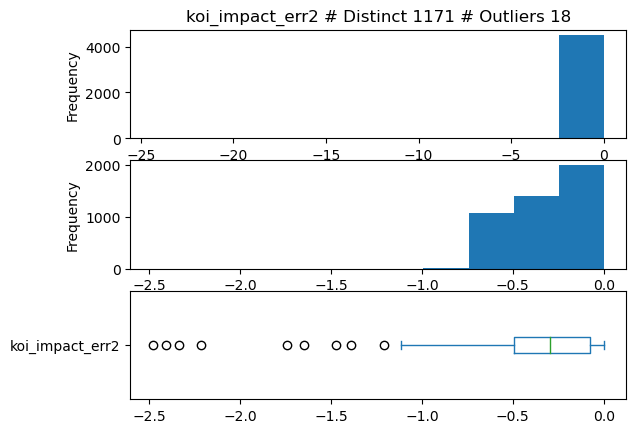

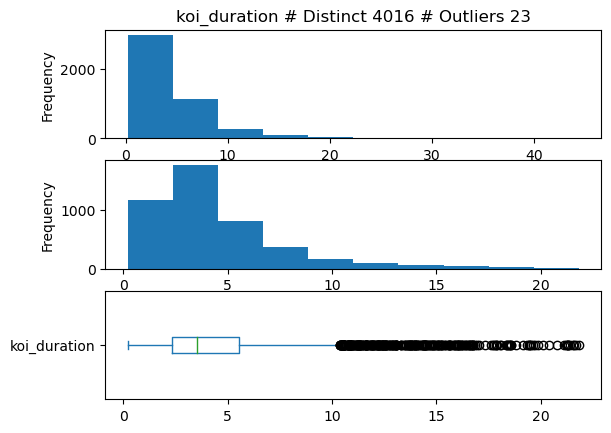

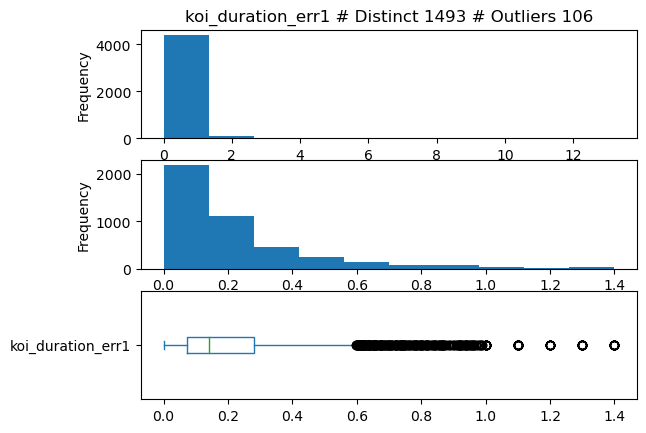

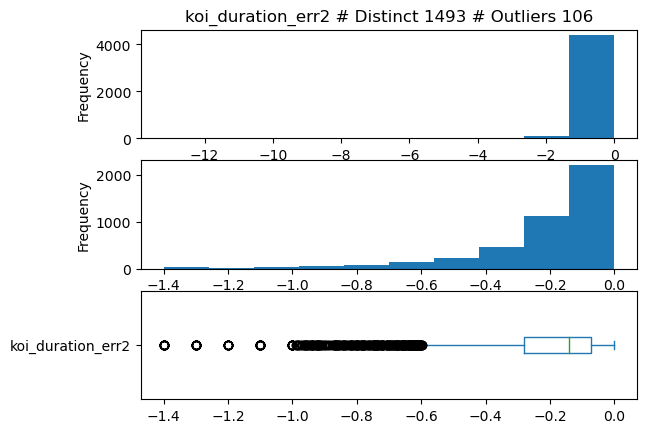

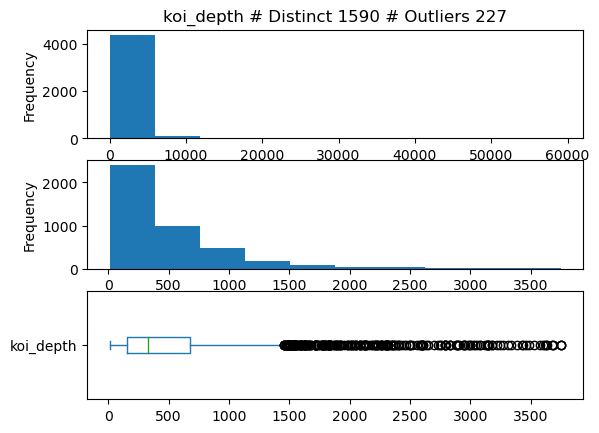

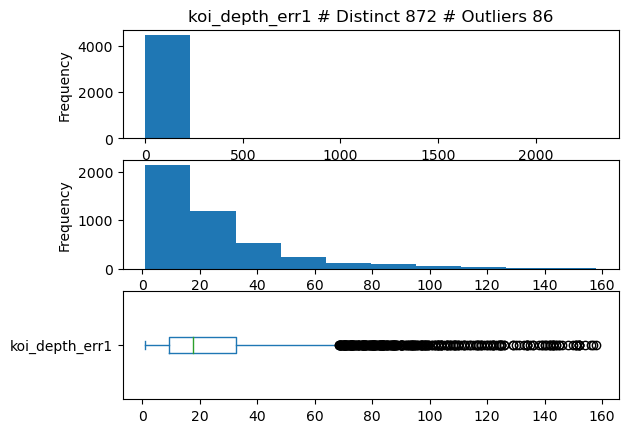

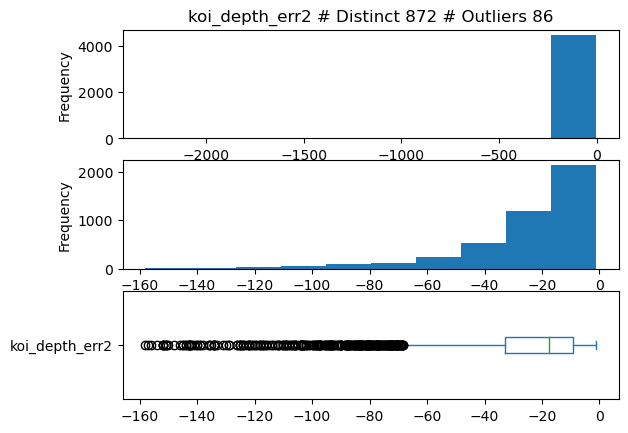

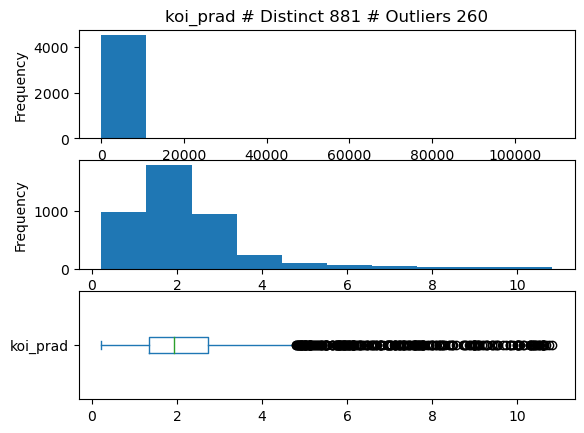

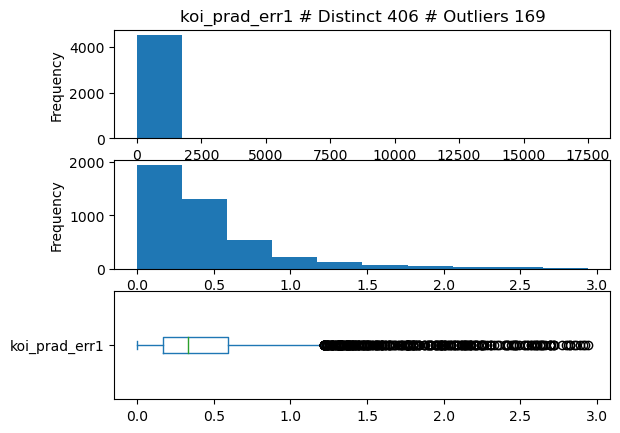

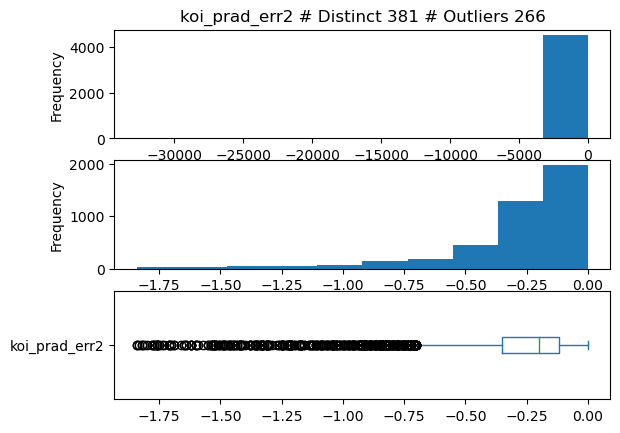

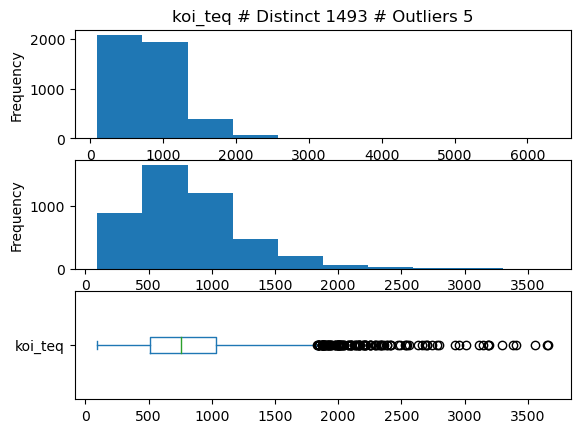

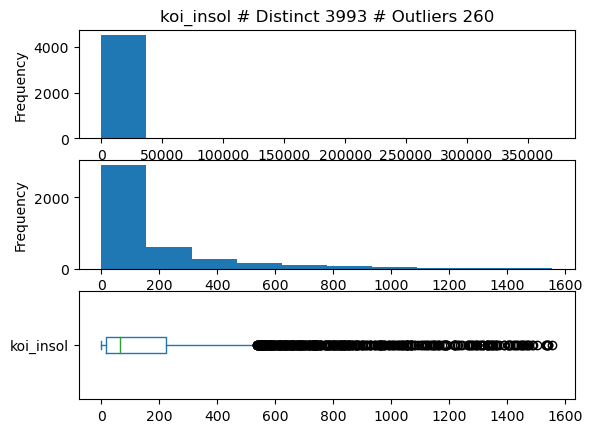

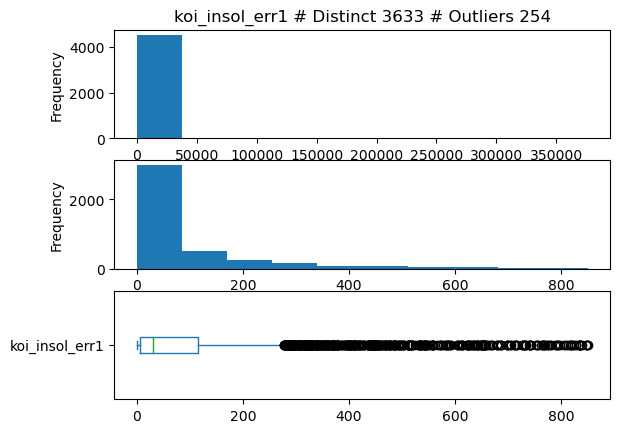

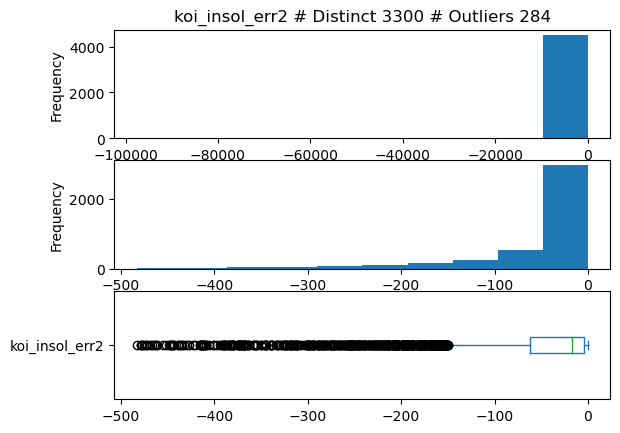

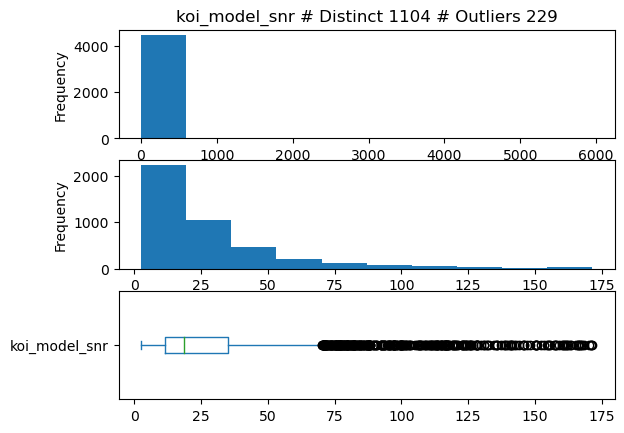

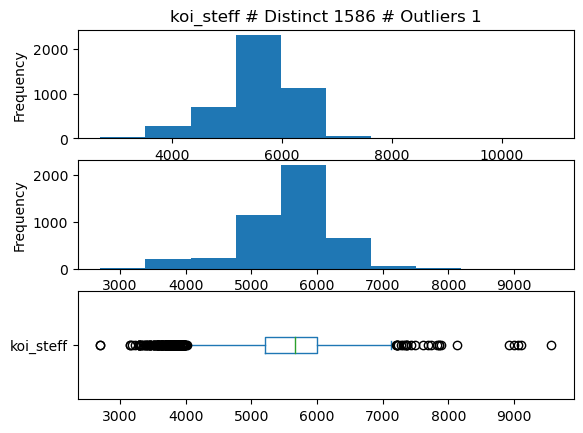

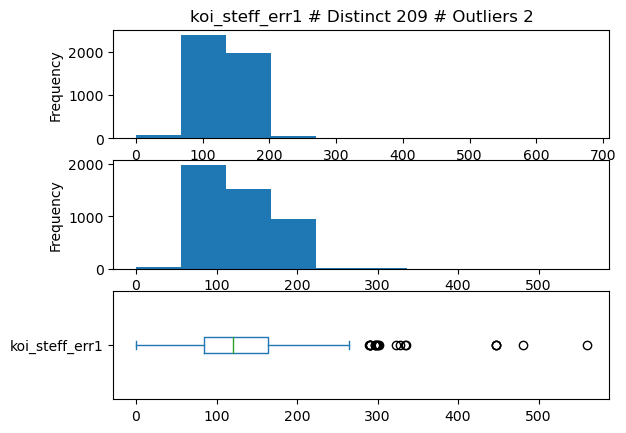

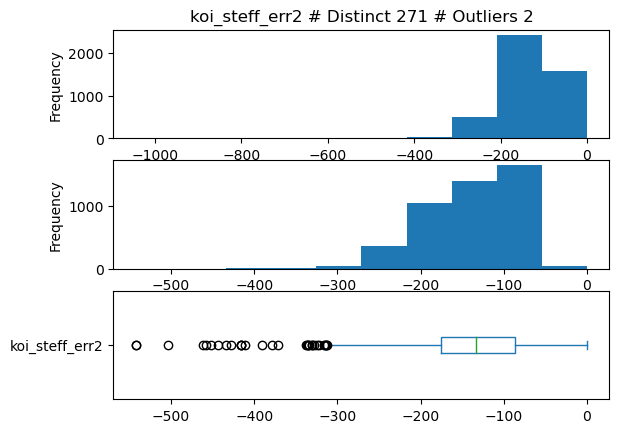

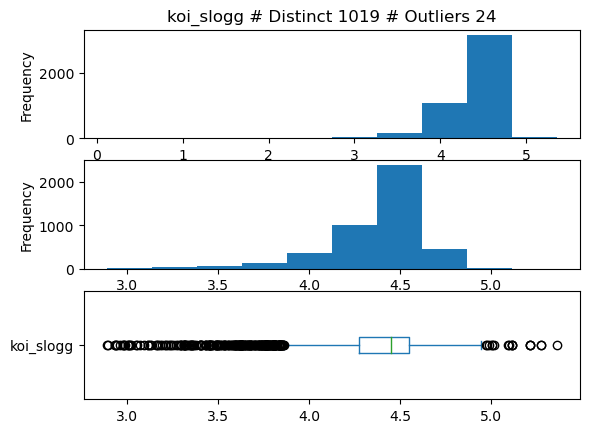

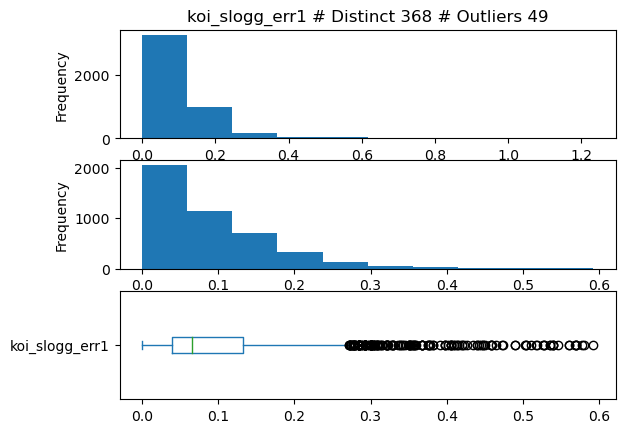

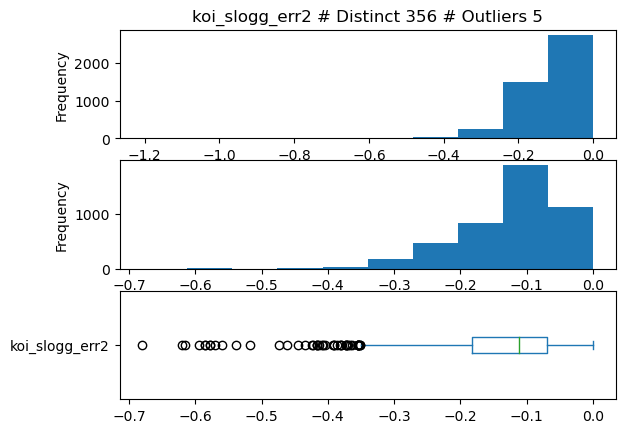

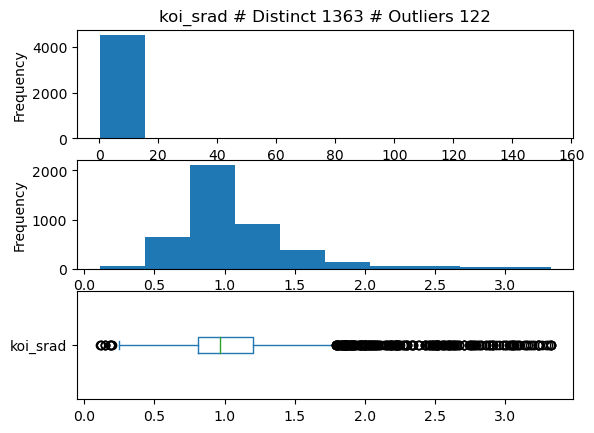

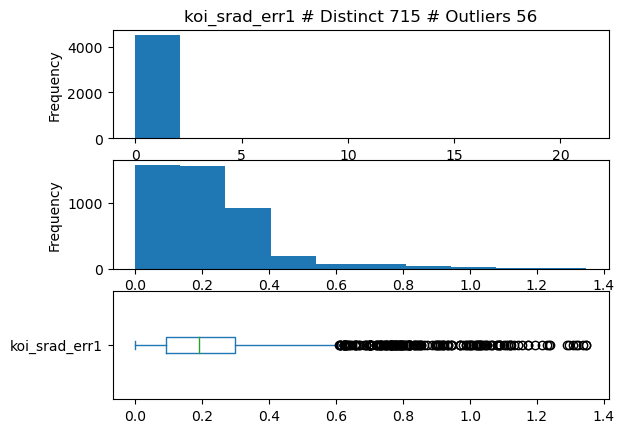

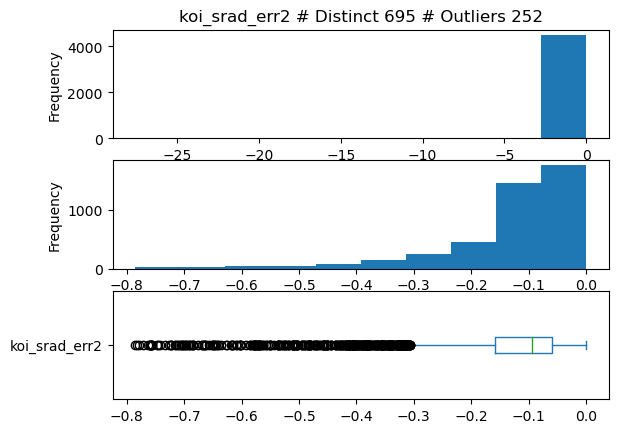

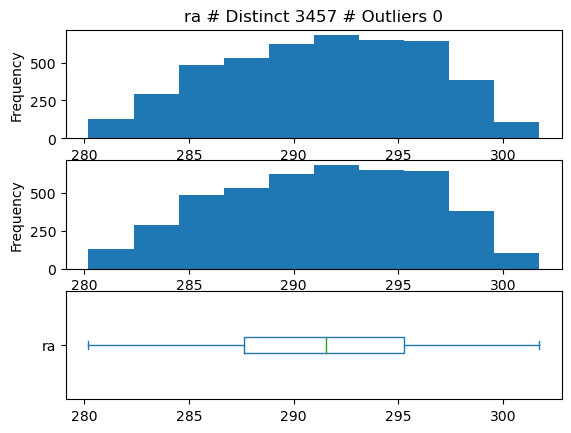

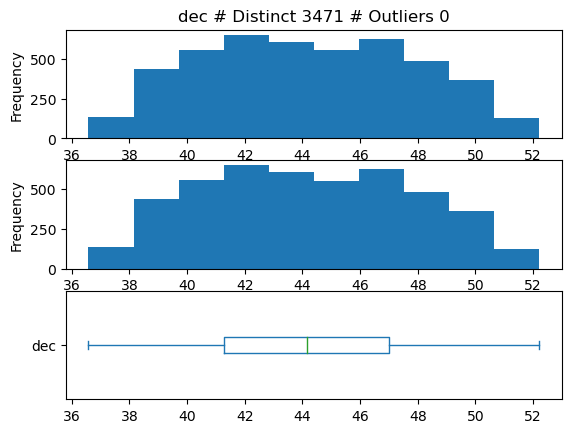

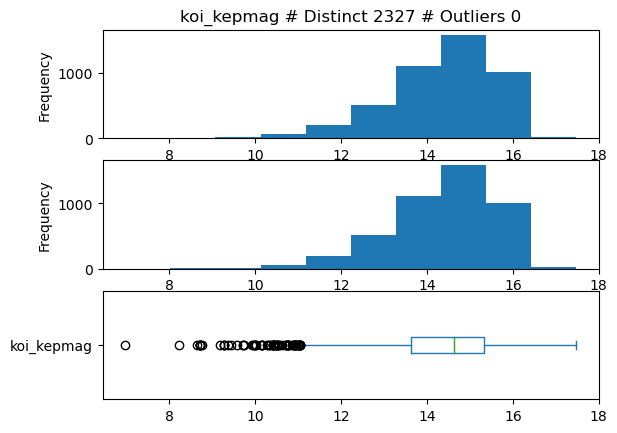

In [26]:
# Decide which plots we will keep

misval_factor = 5

for col in df:
    var = df[col]
    if var.dtype.kind != 'O':
        q1 = var.quantile(0.25)
        q3 = var.quantile(0.75)
        iqr = q3 - q1
        if iqr != 0:
            var_filt = var[~((var < (q1 - misval_factor * iqr)) |(var > (q3 + misval_factor * iqr)))]
            misscount = len(var) - len(var_filt)
            
            fig,axs = plt.subplots(3,1)
            _ = var.plot.hist(ax=axs[0])
            _ = var_filt.plot.hist(ax=axs[1])
            _ = var_filt.plot.box(ax=axs[2],vert=False)
        else:
            fig,axs = plt.subplots(2,1)
            _ = var.plot.hist(ax=axs[0])
            _ = var.plot.box(ax=axs[1],vert=False)    
            misscount = 0
        
        axs[0].set_title(f"{col} # Distinct {len(var.drop_duplicates())} # Outliers {misscount}")
        plt.show()
        

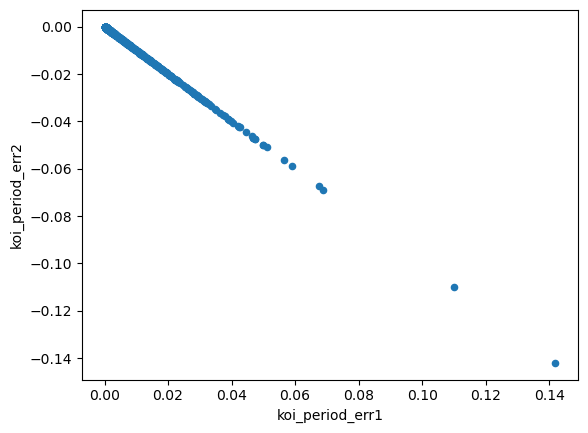

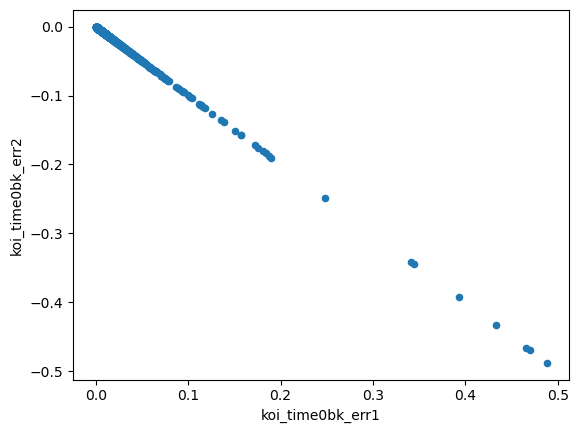

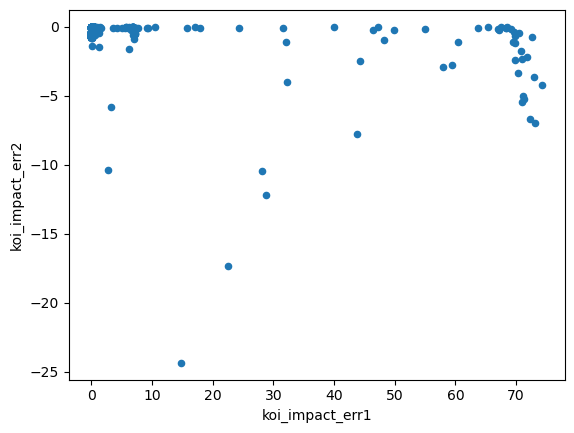

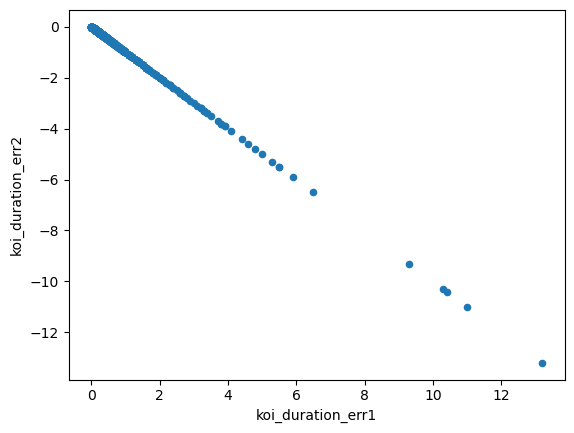

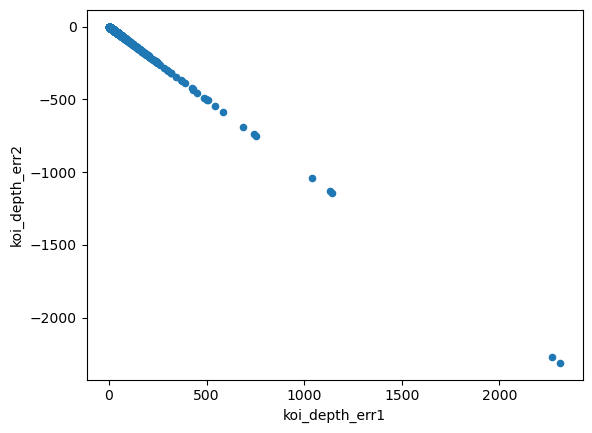

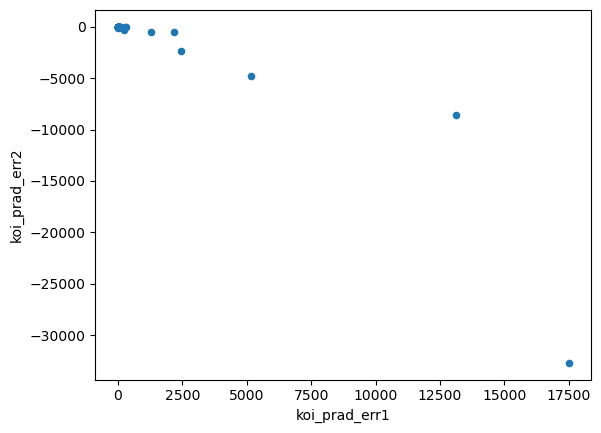

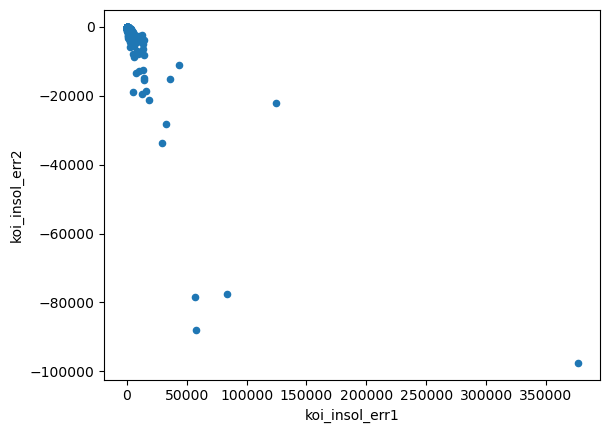

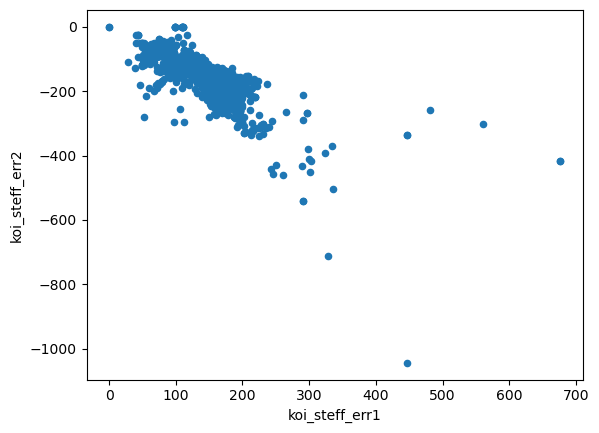

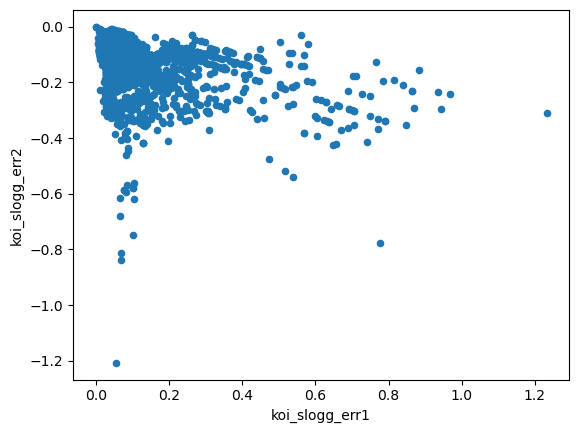

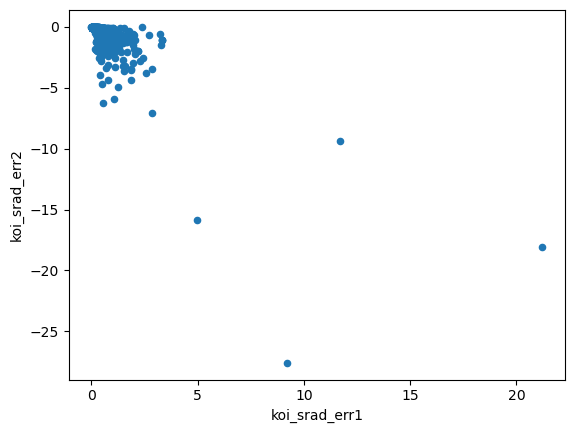

In [41]:
# Look at symetric variables
for var in [x for x in df.columns if x.endswith("err2")]:
    var1 = var[:-1]+"1"
    df.plot.scatter(var1,var)

In [ ]:
def preprocessing(df):
    """
    Perform preprocessing steps:
    1. Drop all missing variables
    """
    return 0
